# Colab에서 Google Drive 파일을 이용해 개발하기

우선 아래에 있는 코드를 실행시켜 드라이브와 연결한 뒤,
드라이브의 colab-data 폴더 안의 파일을 사용하게 설정한다

In [9]:
# 라이브러리 설치 및 드라이브 권한 부여
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive 경로 생성 및 google-drive와 drive 폴더 연동
# 장기간 사용 안 할 시, 연결이 끊긴다고 하니 참고!
!mkdir -p drive
!google-drive-ocamlfuse drive

# drive의 colab-data 경로로 이동
!cd drive/colab-data

# test.csv로 테스트하기
# import pandas as pd
# test = pd.read_csv("test.csv")
# test.head(5)

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


만약 직접 파일을 올리고 싶을 때에는 위의 코드 대신 아래 코드를 실행시켜, /dataset 경로에 파일을 저장할 수 있다.

In [48]:
# 직접 업로드하고 바로 사용할 때에는, files = {"file-name": content} 이런 식으로 오기 때문에,
# 이를 가공한 뒤, utf-8로 decode를 해줘야한다.

from google.colab import files
files = files.upload()

# print(files['sci-total-sentences.txt'].decode('utf-8'))

Saving sci-total-sentences.txt to sci-total-sentences.txt


Matplotlib을 사용할 경우, 한글 폰트로 설정이 되어있는지 확인하고, 없으면 다운받아 사용한다.

In [0]:
# 기본 설정 읽기
import matplotlib.pyplot as plt

# size, family
print('# 설정 되어있는 폰트 사이즈')
print (plt.rcParams['font.size'] ) 
print('# 설정 되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )

In [0]:
# matplotlib의 기본 글꼴이 한글을 지원하지 않으므로,
# 웹 폰트(SpoqaHanSansRegular)를 다운받아 사용합니다.

import matplotlib

!wget https://github.com/spoqa/spoqa-han-sans/blob/master/Subset/SpoqaHanSans/SpoqaHanSansRegular.ttf
!cp SpoqaHanSansRegular.ttf /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!cp SpoqaHanSansRegular.ttf /usr/share/fonts/truetype/

matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='SpoqaHanSansRegular')

아래에 실행시키고 싶은 스크립트를 넣어 실행합니다

loss from 0  step  1000 :  103.34150082015991
loss from 1000  step  2000 :  220.12108229827882
loss from 2000  step  3000 :  254.04820122718812
loss from 3000  step  4000 :  238.29596783065796
loss from 4000  step  5000 :  225.44445011997223
loss from 5000  step  6000 :  203.208908066988
loss from 6000  step  7000 :  191.21186752454466
loss from 7000  step  8000 :  159.65889238125087
loss from 8000  step  9000 :  153.97901159638167
loss from 9000  step  10000 :  146.1674775463343
loss from 10000  step  11000 :  132.64696329462436
loss from 11000  step  12000 :  132.68464250811476
loss from 12000  step  13000 :  113.0322728109903
loss from 13000  step  14000 :  113.27074857195528
loss from 14000  step  15000 :  106.6086546964279
loss from 15000  step  16000 :  106.97202906241014
loss from 16000  step  17000 :  100.6184025519913
loss from 17000  step  18000 :  91.69772674644672
loss from 18000  step  19000 :  91.72978929862516
loss from 19000  step  20000 :  80.39838375123688
loss from 2

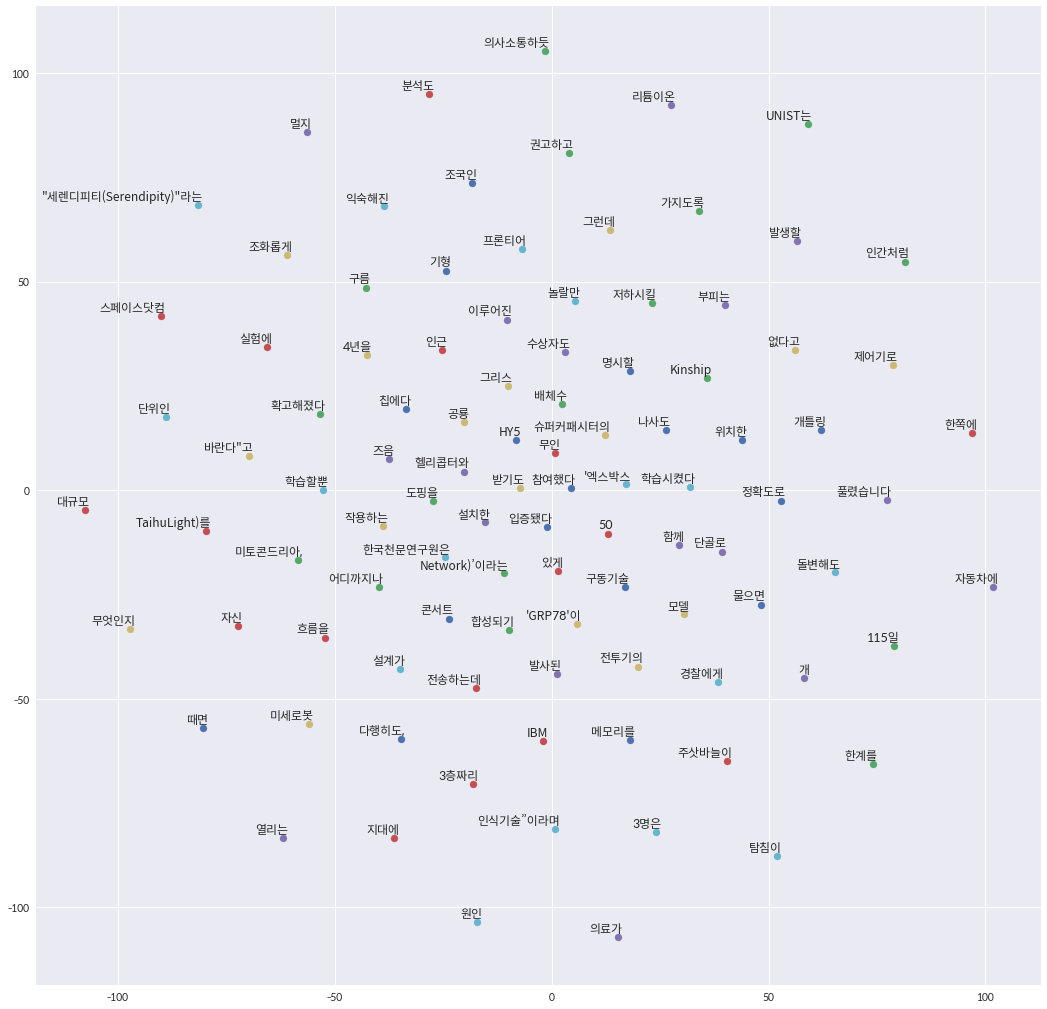

In [58]:
# Code From globin's TensorFlow Tutorials
# https://github.com/golbin/TensorFlow-Tutorials/blob/master/04%20-%20Neural%20Network%20Basic/03%20-%20Word2Vec.py

# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.manifold import TSNE

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## VARIABLES
IS_COLAB = True

FILE_NAME = 'sci-total-sentences.txt'
WORD_COUNT = 1
LOSS_LOG_PER = 1000
plot_only = 100		# number of plots in result graph

# 학습을 반복할 횟수
training_epoch = 30000
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 200
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15


if (not IS_COLAB):
	# 파일 경로 설정
	dirname = os.path.dirname(__file__)
	FILE_NAME = os.path.join(os.path.join(dirname, os.pardir), 'dataset/' + FILE_NAME)

    # 이 파일과 같은 경로에 한글 폰트 파일을 넣어주세요
	font_filename = os.path.join(dirname, 'SpoqaHanSansRegular.ttf') # 폰트 이름 바꾸기

    # matplot 에서 한글을 표시하기 위한 설정
	font_name = matplotlib.font_manager.FontProperties(
        fname=font_filename
                ).get_name()
	font_filename = os.path.join(dirname, 'SpoqaHanSansRegular.ttf') # 폰트 이름 바꾸기

    # matplot 에서 한글을 표시하기 위한 설정
	font_name = matplotlib.font_manager.FontProperties(
        fname=font_filename
                ).get_name()
	matplotlib.rc('font', family=font_name)

# 단어 벡터를 분석해볼 임의의 문장들
def import_sentences():
    with open(FILE_NAME) as f:
        data = f.read().strip()
        sentences = data.split(os.linesep)
    return sentences

# sentences = ["나 고양이 좋다",
#              "나 강아지 좋다",
#              "나 동물 좋다",
#              "강아지 고양이 동물",
#              "여자친구 고양이 강아지 좋다",
#              "고양이 생선 우유 좋다",
#              "강아지 생선 싫다 우유 좋다",
#              "강아지 고양이 눈 좋다",
#              "나 여자친구 좋다",
#              "여자친구 나 싫다",
#              "여자친구 나 영화 책 음악 좋다",
#              "나 게임 만화 애니 좋다",
#              "고양이 강아지 싫다",
#              "강아지 고양이 좋다"]
sentences = import_sentences()

# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}
word_dict_reverse = dict(zip(word_dict.values(), word_dict.keys()))

# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
# 예) 나 게임 만화 애니 좋다
#   -> ([나, 만화], 게임), ([게임, 애니], 만화), ([만화, 좋다], 애니)
#   -> (게임, 나), (게임, 만화), (만화, 게임), (만화, 애니), (애니, 만화), (애니, 좋다)
skip_grams = []

for i in range(0, len(word_sequence)):
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
    target = word_dict[word_sequence[i]]
    context = []
    start_index = (i - WORD_COUNT) if (i > WORD_COUNT) else 0
    for word in word_sequence[start_index:(i + WORD_COUNT)]:
        context.append(word_dict[word])

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels


#########
# 옵션 설정
######
# 다른 설정은 최상단 VARIABLES에 포함되어 있습니다.
# 총 단어 갯수
voc_size = len(word_list)


#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform(
    [voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform(
    [voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    total_loss = 0
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        total_loss += loss_val
        if step % LOSS_LOG_PER == 0:
            print("loss from", (step - LOSS_LOG_PER), " step ", step, ": ", (total_loss / LOSS_LOG_PER))
            total_loss = 0

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()


#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
# for i, label in enumerate(word_list):
#     x, y = trained_embeddings[i]
#     plt.scatter(x, y)
#     plt.annotate(label, xy=(x, y), xytext=(5, 2),
#                  textcoords='offset points', ha='right', va='bottom')

# plt.show()


def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)


try:
  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000)
  plot_only = len(word_dict) if (len(word_dict) < plot_only) else plot_only
  low_dim_embs = tsne.fit_transform(trained_embeddings[:plot_only, :])
  labels = [word_dict_reverse[i] for i in range(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn and matplotlib to visualize embeddings.")
